# COVID-19 Anxiety Monitor
Aim:
- Scrape London-based Tweets related to #Coronavirus
- Apply Vader to run Sentiment Analysis
- Chart Sentiment over the period vs. Virus: How have Londoners' attitudes changed as the virus progressed?

## Import packages

In [1]:
import GetOldTweets3 as got
import twitter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
from sklearn.feature_extraction import DictVectorizer
from tqdm.notebook import tqdm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textacy
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler

### Load Existing Twitter Data

In [104]:
'''Reload Data'''
tweets = pd.read_csv('./data/tweets.csv', parse_dates=['date'])

cases = pd.read_csv('./data/UKDailyConfirmedCases.csv')
cases['DateVal'] = pd.to_datetime(cases['DateVal'], format='%d/%m/%Y')

## Retrieve Tweets, spaCy entity recognition, Vader scorer
- Twitter Official API has time constraints, you can't get older tweets than a week. 
- Some tools provide access to older tweets but in the most of them you have to spend some money before.
- GetOldTweets3 mimics a Twitter search so we can search older tweets: when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider.

In [71]:
def getoldtweets(since, until, query='#Coronavirus', near='London, UK', lang='en', maxtweets=10000):
    '''Wrap TweetCriteria class in a function to enable dynamic setting of variables when called'''
    
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('{}'.format(query))\
                                           .setSince('{}'.format(since))\
                                           .setUntil('{}'.format(until))\
                                           .setNear('{}'.format(near))\
                                           .setLang('{}'.format(lang))\
                                           .setMaxTweets(maxtweets)

    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets

def process_text(text_col, pos=['PROPN']):
    '''Clean punctuation and tokenize tweets. Filter tokens by token.pos_ specified. Entity Recognition'''
    
    nlp = spacy.load('en_core_web_sm')

    persons = [('boris johnson','johnson'),('boris','johnson'),('johnson','johnson'),('prime minister','johnson'),
               ('primeminister','johnson'),('matt','hancock'),('hancock','hancock'),('matt hancock','hancock'),
               ('health secretary','hancock'),('healthsecretary','hancock')]
    orgs = [('nhs','nhs'),('government','government')]
    
    tokens = []
    people = []
    organisations = []
    custom_people = []
    custom_organisations = []

    for parsed in tqdm(nlp.pipe(text_col)):
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()

        tokens.append(doc_)

        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                if ent.label_ == 'PERSON':
                    named_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''

        people.append(named_persons)
        organisations.append(named_orgs)
        
    ruler_boris = EntityRuler(nlp, overwrite_ents=True)
    ruler_orgs = EntityRuler(nlp, overwrite_ents=True)

    for (p,i) in persons:
        ruler_boris.add_patterns([{"label": "PERSON", "pattern": [{"LOWER": p}], "id": i}])
    for (o,i) in orgs:
        ruler_orgs.add_patterns([{"label": "ORG", "pattern": [{"LOWER": o}], 'id': i}])

    ruler = EntityRuler(nlp)
    ruler.add_patterns(ruler_orgs.patterns)
    ruler.add_patterns(ruler_boris.patterns)

    nlp.add_pipe(ruler)

    for parsed in tqdm(nlp.pipe(text_col, disable=['ner'])):
        if parsed.ents:
            for ent in parsed.ents:
                custom_persons = ''
                custom_orgs = ''
                if ent.label_ == 'PERSON':
                    custom_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    custom_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            custom_persons = ''
            custom_orgs = ''

        custom_persons = custom_persons.strip()
        custom_orgs = custom_orgs.strip()

        custom_people.append(custom_persons)
        custom_organisations.append(custom_orgs)
        
    return tokens, people, organisations, custom_people, custom_organisations

def vader_scorer(df):
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores

In [86]:
'''Collate tweets per day into a tweets_dict'''

tweets_dict = {}
start = '2020-04-03'
until = (datetime.today()-timedelta(days=1)).date()
datelist = pd.date_range(start, end=until).tolist()
    
for (i,date) in enumerate(tqdm(datelist)):
    tweets_dict[str(date)[:10]] = getoldtweets(str(date)[:10], str(date+timedelta(days=1))[:10])
    print('Completed {}: {} of {} dates'.format(date,i+1,len(datelist)))
    
tweets_ls = []
for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        tweets_ls.append(tweet)

print('Total No. Tweets retrieved: {}'.format(len(tweets_ls)))
print('For Date Range: {} - {}'.format(start,datetime.today()-timedelta(days=1)))

Completed 2020-04-03 00:00:00: 1 of 1 dates

Total No. Tweets retrieved: 4213
For Date Range: 2020-04-03 - 2020-04-03 08:41:34.618784


In [87]:
'''Creating Dataframe of newly-returned tweets'''

tweets_df = []

for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        tweets_df.append([tweet.username, tweet.id, tweet.date, tweet.favorites, tweet.hashtags,
                          tweet.mentions, tweet.retweets, tweet.replies, tweet.text])

tweets_df = pd.DataFrame(tweets_df,columns=['username','tweet_id','date','favorites','hashtags',
                                            'mentions','retweets','replies','text'])


'''spaCy tokenization: Proper Nouns, Named Entity Recognition, Custom Entity Recognition'''

propn_string, people, orgs, topical_persons, topical_orgs = process_text(tweets_df['text'])

pd.options.mode.chained_assignment = None

tweets_df['topical_persons'] = topical_persons
tweets_df['topical_orgs'] = topical_orgs
tweets_df['persons'] = people
tweets_df['orgs'] = orgs
tweets_df['propn'] = propn_string

'''Sentiment Scorer'''

vader_scores = vader_scorer(tweets_df)
tweets_df = pd.concat([tweets_df,vader_scores], axis=1)


'''Appending new tweets to existing data, write to tweets.csv file'''

tweets = pd.concat([tweets,tweets_df])
tweets = tweets.drop_duplicates(subset='tweet_id', ignore_index=True)

tweets.to_csv('./data/tweets.csv', index=False)

## Sentiment Analysis

VaderSentiment metrics explained:
- Pos: Proportion of the text that falls into the positive category: ie. no.pos words / total no.words
- Neu: Proportion of the text that falls into the neutral category: ie. no.neu words / total no.words
- Neg: Proportion of the text that falls into the negative category: ie. no.neg words / total no.words

... so these 3 metrics should up to 1 for a given text

- Compound: Summing the valence scores of each word in the text, and normalized to between -1 (neg) and 1 (pos). 
  - This gives us a polarity measure for that text.
  - It's normalized so can be used to compare different texts
  - Note - researchers usually use +/-0.05 as the threshold for becoming pos/neg

### Sentiment Progression by date

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


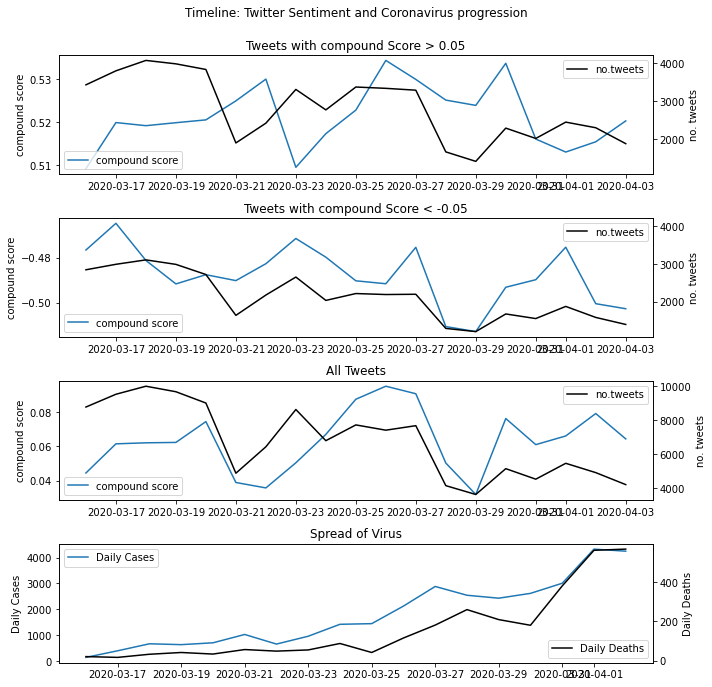

In [109]:
'''Group Sentiment Data by Date and plot alongside no.cases'''

start_date = '2020-03-16' # Choose date to start plotting from
score = 'compound' # Choose sentiment metric
pos_threshold = 0.05 # Choose threshold for positive valence
neg_threshold = -0.05 # Choose threshold for negative valence

'''Filter for valences to plot'''
tweets_pos_valence = tweets[(tweets['{}'.format(score)]>pos_threshold)]
tweets_neg_valence = tweets[(tweets['{}'.format(score)]<neg_threshold)]

'''Merge with no.cases data'''
tweets_pos_valence = tweets_pos_valence.set_index('date').groupby(tweets_pos_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_neg_valence = tweets_neg_valence.set_index('date').groupby(tweets_neg_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_all_valence = tweets.set_index('date').groupby(tweets.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})

cases_plt = cases.set_index('DateVal')
cases_plt['DailyCases_shifted_1'] = cases_plt.CMODateCount.shift(1)
cases_plt['DailyDeaths_shifted_1'] = cases_plt.DailyDeaths.shift(1)

tweets_pos_valence = pd.merge(tweets_pos_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_neg_valence = pd.merge(tweets_neg_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_all_valence = pd.merge(tweets_all_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

'''Filter for dates to plot'''
tweets_pos_valence = tweets_pos_valence[tweets_pos_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_neg_valence = tweets_neg_valence[tweets_neg_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_all_valence = tweets_all_valence[tweets_all_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]

'''Plot'''
fig, ax = plt.subplots(figsize=(10,10), sharex=True)
fig.suptitle('Timeline: Twitter Sentiment and Coronavirus progression')

# add subplots to current figure and assign them to variables
ax0 = plt.subplot(411)
ax1 = ax0.twinx()
ax2 = plt.subplot(412)
ax3 = ax2.twinx()
ax4 = plt.subplot(413)
ax5 = ax4.twinx()
ax6 = plt.subplot(414)
ax7 = ax6.twinx()

# share y-axes for no.tweets:
ax1.get_shared_y_axes().join(ax1, ax3)

# Plot data on their respective axes:
ax0.plot(tweets_pos_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax0.set_ylabel('{} score'.format(score))
ax0.legend(loc='lower left')
ax0.set_title('Tweets with {} Score > {}'.format(score,pos_threshold))

ax1.plot(tweets_pos_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax1.set_ylabel('no. tweets')
ax1.legend(loc='upper right')

ax2.plot(tweets_neg_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax2.set_ylabel('{} score'.format(score))
ax2.legend(loc='lower left')
ax2.set_title('Tweets with {} Score < {}'.format(score,neg_threshold))

ax3.plot(tweets_neg_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax3.set_ylabel('no. tweets')
ax3.legend(loc='upper right')

ax4.plot(tweets_all_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax4.set_ylabel('{} score'.format(score))
ax4.legend(loc='lower left')
ax4.set_title('All Tweets')

ax5.plot(tweets_all_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax5.set_ylabel('no. tweets')
ax5.legend(loc='upper right')

ax6.plot(tweets_neg_valence['CMODateCount'], label='Daily Cases')
ax6.set_ylabel('Daily Cases')
ax6.legend(loc='upper left')
ax6.set_title('Spread of Virus')

ax7.plot(tweets_neg_valence['DailyDeaths'], label='Daily Deaths', c='k')
ax7.set_ylabel('Daily Deaths')
ax7.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

### Correlations: Sentiment vs Disease Progression
Summary:
- The Correlation matrix below suggests an increase in no.tweets and also higher negative valence as the cases and deaths increased.
- Introduding a 1-day lag increases this correlation, suggesting a lagged effect of the effect on sentiment of the disease
- We also visualise this through scatter plots further below

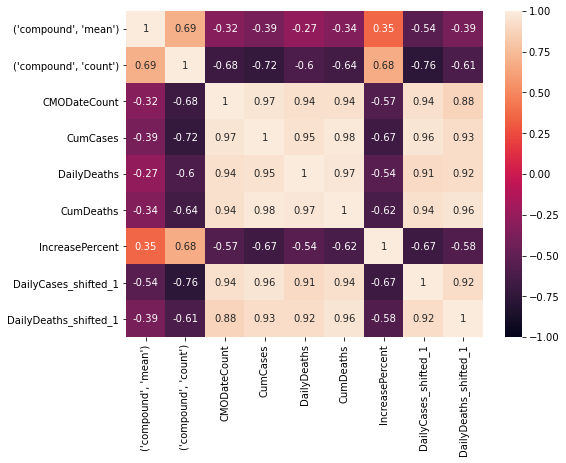

In [106]:
'''HeatMap of Correlations'''
plt.figure(figsize=(8,6))
sns.heatmap(tweets_neg_valence.iloc[1:,:].corr(), vmin=-1, vmax=1, annot=True);

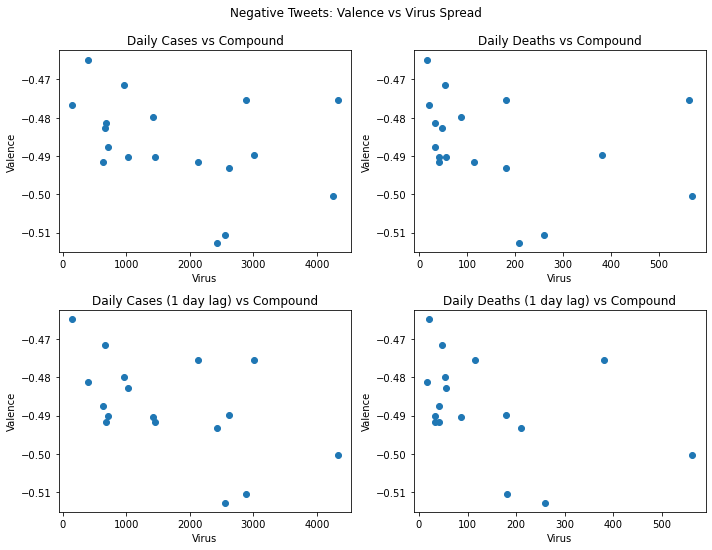

In [107]:
'''Scatter Plots of Valence of Negative Tweets vs Cases and Deaths'''

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.suptitle('Negative Tweets: Valence vs Virus Spread')

ax[0,0].scatter(tweets_neg_valence['CMODateCount'],tweets_neg_valence[('compound','mean')])
ax[0,0].set_xlabel('Virus')
ax[0,0].set_ylabel('Valence')
ax[0,0].set_title('Daily Cases vs Compound')

ax[0,1].scatter(tweets_neg_valence['DailyDeaths'],tweets_neg_valence[('compound','mean')])
ax[0,1].set_xlabel('Virus')
ax[0,1].set_ylabel('Valence')
ax[0,1].set_title('Daily Deaths vs Compound')

ax[1,0].scatter(tweets_neg_valence.iloc[1:,-2],tweets_neg_valence.iloc[1:,0])
ax[1,0].set_xlabel('Virus')
ax[1,0].set_ylabel('Valence')
ax[1,0].set_title('Daily Cases (1 day lag) vs Compound')

ax[1,1].scatter(tweets_neg_valence.iloc[1:,-1],tweets_neg_valence.iloc[1:,0])
ax[1,1].set_xlabel('Virus')
ax[1,1].set_ylabel('Valence')
ax[1,1].set_title('Daily Deaths (1 day lag) vs Compound')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

- It appears there is some relationship between sentiment and the disease, especially after introducing a 1-day lag to the daily statistics which yields a more linear relationship.
- However more datapoints are needed.

In [ ]:
# Can you see any relationships worth modelling vs. no. cases?
# Look at the papers saved... can you predict the epidemic spread based on sentiment?

## Aspect-Based Analysis

In [ ]:
# For now look into adding aspects, e.g. Boris, perhaps through vectorization?
    # And see if that aspect was neg / pos?
# Can you see what unsupervised learning (clustering) has to tell us about these tweets?